> Required Imports

In [2]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
from os.path import getsize
from os import remove
from IPython.display import Audio
from gtts import gTTS
from tensorflow import keras
import noisereduce as nr
from config import CONFIG

from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

> Get the duration - the length of audio our reconstruction can be, (i.e., all the models are trained on)

In [4]:
df = pd.read_csv(CONFIG.get("files", "base_data"))
df['filepath']=df['filepath'].map(lambda x: x.replace('\\','/'))
smallest_file = min(df["filepath"], key=getsize)
y, sr = librosa.load(smallest_file)
y, _ = librosa.effects.trim(y)
duration = librosa.get_duration(y=y, sr=sr)
display(duration)

3.960090702947846

> Given a text, find the spectrogram of Google Assistant speaking the text

In [5]:
language = 'en'
google_filepath = CONFIG.get("files", "reconst_models") # Any directory where we can create and delete the "temporary" google audio file

def text_to_spectrogram(text):
    tts = gTTS(text=text, lang=language, slow=False)
    tts.save(google_filepath + "temp.wav")
    y, sr = librosa.load(google_filepath + "temp.wav")
    remove(google_filepath + "temp.wav")
    if len(y) > int(sr*duration):
        y_new = y[:int(sr*duration)]
    else:
        y_new = librosa.util.fix_length(y, size=int(sr*duration))
    ps_google = librosa.feature.melspectrogram(y=y_new, sr=sr)
    return ps_google

> Based on the user's choice, get the respective speaker's embedding

In [ ]:
celebs_df = pd.read_csv(CONFIG.get("speaker_embedding"))

def get_speaker_signature(speaker_id):
    alpha_celeb = celebs_df[celebs_df["speaker_id"] == speaker_id].drop(columns=["speaker_id"]).iloc[0].values
    return alpha_celeb

get_speaker_signature("id10001")

array([0., 0., 0., ..., 0., 0., 0.])

> Load the decoder and define a function to decode the convolutions to spectrogram

In [ ]:
loaded_model = keras.models.load_model(CONFIG.get("files", "recog_model"))

weights = []
for layr in loaded_model.layers:
    weights.append(layr.get_weights())

model = Sequential()
model.add(Conv2D(input_shape=(128,171,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))

for i, layr in enumerate(model.layers):
    model.layers[i].set_weights(weights[i])
    model.layers[i].trainable = False

def conv(ps):
    return model.predict(np.array([ps.reshape((128,171,1))]), verbose=0)[0]

models=[]
for i in range(18):
    models.append(keras.models.load_model(CONFIG.get("files", "reconst_models") + f'model_{i}'))

def spectro_from_embedding(embedding):
    prediction=[]
    for model in models:
        prediction.append(model.predict(np.array([embedding]),verbose=0)[0])
    return np.array(prediction)

> Try reconstruction on a sample text and speaker

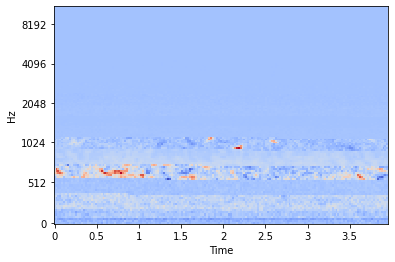

In [ ]:
text = "You know it's fake right?"
speaker = "id10001"

x = conv(text_to_spectrogram(text)) + get_speaker_signature(speaker)
ps = spectro_from_embedding(x)
ps = ps.reshape((128,171))
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [ ]:
y=librosa.feature.inverse.mel_to_audio(ps,sr=sr)
Audio(data=y, rate=sr)

> Noise reduced version of the same audio

In [ ]:
reduced_noise = nr.reduce_noise(y, sr=sr)
Audio(data=reduced_noise, rate=sr)